In [26]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import MultiTaskLassoCV
import plotly.graph_objs as go
from plotly.offline import plot, init_notebook_mode
import matplotlib.pyplot as plt

init_notebook_mode(connected=True)

In [27]:
# Create the feature matrix X
def create_feature_matrix(data, lags=[1, 2]):
    X = pd.DataFrame()
    for lag in lags:
        for ticker in data.columns:
            X[f'{ticker}_lag_{lag}'] = data[ticker].shift(lag)
    X = X.dropna()
    return X

In [28]:
# Split data into training and testing sets
def split_data(X, y):
    mid_point = len(X) // 2
    X_train, X_test = X[:mid_point], X[mid_point:]
    y_train, y_test = y[:mid_point], y[mid_point:]
    return X_train, X_test, y_train, y_test

In [29]:
# Calculate gamma for prediction intervals
def calculate_gamma(y_train2, predicted_train2, alpha=0.1):
    residuals = np.abs(y_train2 - predicted_train2)  # Calculate residuals for each target ticker
    sorted_residuals = np.sort(residuals, axis=0)    # Sort residuals along the time axis for each ticker
    gamma_index = int((1 - alpha) * len(sorted_residuals))  # Index for gamma
    gamma = sorted_residuals[gamma_index, :]  # Select gamma for each target ticker
    return gamma

In [30]:
# Function to evaluate model for given tickers and a target ticker
def evaluate_model(target_tickers, all_data, fixed_tickers, additional_tickers):
    results = []
    for k in range(0, 11):  # Loop to include up to 10 additional tickers
        tickers_used = fixed_tickers + additional_tickers[:k]
        if len(tickers_used) > 20:  # Stop after processing 20 tickers
            break
        try:
            print(f"Evaluating {len(tickers_used)} tickers for targets {target_tickers}: {tickers_used}")
            data_used = all_data[tickers_used]

            # Create the feature matrix using the selected tickers
            X = create_feature_matrix(data_used)
            y = all_data[target_tickers].loc[X.index]

            print(f"Data used shape: {data_used.shape}")
            print(f"Feature matrix shape: {X.shape}")

            if X.empty or y.empty:
                print(f"Skipping {len(tickers_used)} tickers: Empty DataFrame")
                continue

            # Adding additional features to X
            new_features = {}
            for ticker in tickers_used:
                if f'{ticker}_lag_1' in X.columns and f'{ticker}_lag_2' in X.columns:
                    diff_squared = (X[f'{ticker}_lag_1'] - X[f'{ticker}_lag_2']) ** 2
                    volatility = (X[f'{ticker}_lag_1'] - X[f'{ticker}_lag_2']) / X[f'{ticker}_lag_2']
                    new_features[f'{ticker}_diff_squared'] = diff_squared
                    new_features[f'{ticker}_volatility'] = volatility

            if new_features:
                new_features_df = pd.DataFrame(new_features, index=X.index)
                X = pd.concat([X, new_features_df], axis=1)
                X = X.copy()  # Create a de-fragmented copy of the DataFrame

            print(f"Feature matrix after adding new features shape: {X.shape}")

            # Splitting the data
            X_train, X_test, y_train, y_test = split_data(X, y)

            print(f"Train/Test split shapes: {X_train.shape}, {X_test.shape}")

            if X_train.empty or y_train.empty or X_test.empty or y_test.empty:
                print(f"Skipping {len(tickers_used)} tickers: Empty train/test split")
                continue

            # Splitting X_train into train1 (90%) and train2 (10%)
            train1_end = int(len(X_train) * 0.9)
            X_train1, X_train2 = X_train[:train1_end], X_train[train1_end:]
            y_train1, y_train2 = y_train[:train1_end], y_train[train1_end:]

            # Feature scaling
            scaler_X = StandardScaler().fit(X_train1)
            X_train1_scaled = scaler_X.transform(X_train1)
            X_train2_scaled = scaler_X.transform(X_train2)
            X_test_scaled = scaler_X.transform(X_test)

            scaler_Y = StandardScaler().fit(y_train1)
            y_train1_scaled = scaler_Y.transform(y_train1)
            y_train2_scaled = scaler_Y.transform(y_train2)
            y_test_scaled = scaler_Y.transform(y_test)

            # Debugging: Check the scaled values
            print(f"Scaled y_train1: {y_train1_scaled[:5]}")
            print(f"Scaled y_train2: {y_train2_scaled[:5]}")
            print(f"Scaled y_test: {y_test_scaled[:5]}")

            # Machine learning model with regularization
            multitask_lasso = MultiTaskLassoCV(max_iter=10000)  # Changed to MultiTaskLassoCV
            multitask_lasso.fit(X_train1_scaled, y_train1_scaled)

            # Predict using the model
            predicted_train1_scaled = multitask_lasso.predict(X_train1_scaled)
            predicted_train2_scaled = multitask_lasso.predict(X_train2_scaled)
            predicted_test_scaled = multitask_lasso.predict(X_test_scaled)

            # Compute Mean Squared Error (MSE)
            mse_train1 = np.mean(np.power(y_train1_scaled - predicted_train1_scaled, 2), axis=0)
            mse_train2 = np.mean(np.power(y_train2_scaled - predicted_train2_scaled, 2), axis=0)
            mse_test = np.mean(np.power(y_test_scaled - predicted_test_scaled, 2), axis=0)

            # Log MSE values
            print(f"MSE Train1: {mse_train1}, MSE Train2: {mse_train2}, MSE Test: {mse_test}")

            # Ensure arrays are 2D before inverse transforming
            predicted_train1_scaled = predicted_train1_scaled.reshape(-1, len(target_tickers))
            predicted_train2_scaled = predicted_train2_scaled.reshape(-1, len(target_tickers))
            predicted_test_scaled = predicted_test_scaled.reshape(-1, len(target_tickers))

            # Inverse transform the scaled predictions and actual values
            predicted_train1 = scaler_Y.inverse_transform(predicted_train1_scaled)
            predicted_train2 = scaler_Y.inverse_transform(predicted_train2_scaled)
            predicted_test = scaler_Y.inverse_transform(predicted_test_scaled)
            y_train1_inv = scaler_Y.inverse_transform(y_train1_scaled)
            y_train2_inv = scaler_Y.inverse_transform(y_train2_scaled)
            y_test_inv = scaler_Y.inverse_transform(y_test_scaled)

            # Calculate gamma for prediction intervals
            gamma = calculate_gamma(y_train2_inv, predicted_train2)

            # Evaluate direction accuracy
            direction_accuracy_train1 = np.mean((np.sign(np.diff(y_train1.values, axis=0)) == np.sign(np.diff(predicted_train1, axis=0))).astype(int), axis=0)
            direction_accuracy_train2 = np.mean((np.sign(np.diff(y_train2.values, axis=0)) == np.sign(np.diff(predicted_train2, axis=0))).astype(int), axis=0)
            direction_accuracy_test = np.mean((np.sign(np.diff(y_test.values, axis=0)) == np.sign(np.diff(predicted_test, axis=0))).astype(int), axis=0)

            print(f"Processed {len(tickers_used)} tickers")

            # Predictions and actual values for plotting
            predictions = {
                'y_train1': y_train1_inv,
                'y_train2': y_train2_inv,
                'y_test': y_test_inv,
                'predicted_train1': predicted_train1,
                'predicted_train2': predicted_train2,
                'predicted_test': predicted_test,
                'gamma': gamma
            }

            for i, target in enumerate(target_tickers):
                results.append({
                    'Num_Tickers': len(tickers_used),
                    'Target_Ticker': target,
                    'MSE_Train1': mse_train1[i],
                    'MSE_Train2': mse_train2[i],
                    'MSE_Test': mse_test[i],
                    'Direction_Accuracy_Train1': direction_accuracy_train1[i],
                    'Direction_Accuracy_Train2': direction_accuracy_train2[i],
                    'Direction_Accuracy_Test': direction_accuracy_test[i],
                    'Predictions': {key: value[:, i] if key != 'gamma' else value[i] for key, value in predictions.items()}
                })

        except Exception as e:
            print(f"Error processing {len(tickers_used)} tickers: {e}")
            continue

    return results


In [31]:
# Function to plot actual vs predicted stock prices
def plot_actual_vs_predicted(predictions, target):
    gamma = predictions['gamma']
    upper_bound = predictions['predicted_test'] + gamma
    lower_bound = predictions['predicted_test'] - gamma

    plt.figure(figsize=(14, 7))
    plt.plot(predictions['y_train1'], label='Actual Train1', color='black', linestyle='dashed')
    plt.plot(predictions['predicted_train1'], label='Predicted Train1', color='blue')
    plt.plot(range(len(predictions['y_train1']), len(predictions['y_train1']) + len(predictions['y_train2'])), predictions['y_train2'], label='Actual Train2', color='gray', linestyle='dashed')
    plt.plot(range(len(predictions['y_train1']), len(predictions['y_train1']) + len(predictions['y_train2'])), predictions['predicted_train2'], label='Predicted Train2', color='cyan')
    plt.plot(range(len(predictions['y_train1']) + len(predictions['y_train2']), len(predictions['y_train1']) + len(predictions['y_train2']) + len(predictions['y_test'])), predictions['y_test'], label='Actual Test', color='black', linestyle='dashed')
    plt.plot(range(len(predictions['y_train1']) + len(predictions['y_train2']), len(predictions['y_train1']) + len(predictions['y_train2']) + len(predictions['y_test'])), predictions['predicted_test'], label='Predicted Test', color='red')
    plt.fill_between(range(len(predictions['y_train1']) + len(predictions['y_train2']), len(predictions['y_train1']) + len(predictions['y_train2']) + len(predictions['y_test'])), lower_bound, upper_bound, color='orange', alpha=0.3, label='Prediction Interval')
    plt.xlabel('Days')
    plt.ylabel('Stock Price')
    plt.title(f'Actual vs Predicted Stock Prices for {target}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate coverage for the entire test period
    coverage_full = np.mean((predictions['y_test'] >= lower_bound) & (predictions['y_test'] <= upper_bound))
    print(f"Coverage for the entire test period: {coverage_full * 100:.2f}%")

    # Calculate coverage for the first 10% of the test period
    test_10_percent = int(0.1 * len(predictions['y_test']))
    coverage_10_percent = np.mean((predictions['y_test'][:test_10_percent] >= lower_bound[:test_10_percent]) & (predictions['y_test'][:test_10_percent] <= upper_bound[:test_10_percent]))
    print(f"Coverage for the first 10% of the test period: {coverage_10_percent * 100:.2f}%")


In [32]:
ticker_list = ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK', 'USB', 'AMGN', 'SYK', 'ADI', 'ZTS', 'CVS', 'C', 'COP', 'CL', 'ECL', 'APD', 'SHW', 'ICE', 'LMT', 'LRCX', 'ETN', 'FDX', 'VRTX', 'MPC', 'TGT', 'BMY', 'NSC', 'CI', 'REGN', 'DD', 'TRV', 'CMG', 'AON', 'F', 'GM', 'APTV', 'APH', 'CDW', 'KMB', 'BSX']


In [33]:
# Download data for all tickers
all_data = yf.download(ticker_list, start='2010-06-29', end='2014-06-24')['Adj Close']

[*********************100%%**********************]  94 of 94 completed


In [34]:
# Fill missing values and forward-fill any remaining missing data
all_data.ffill(inplace=True)
all_data.bfill(inplace=True)

In [35]:
# Evaluate models for different number of tickers in the feature matrix
fixed_tickers = ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM']
additional_tickers = [ticker for ticker in ticker_list if ticker not in fixed_tickers]
target_tickers = ['GOOGL', 'AAPL', 'AMZN']

In [36]:
results = evaluate_model(target_tickers, all_data, fixed_tickers, additional_tickers)


Evaluating 10 tickers for targets ['GOOGL', 'AAPL', 'AMZN']: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM']
Data used shape: (1003, 10)
Feature matrix shape: (1001, 20)
Feature matrix after adding new features shape: (1001, 40)
Train/Test split shapes: (500, 40), (501, 40)
Scaled y_train1: [[-2.41185444 -1.41361608 -2.54577694]
 [-2.46729829 -1.43219344 -2.6111246 ]
 [-2.47634909 -1.41180622 -2.57809174]
 [-2.2098809  -1.29074674 -2.45709065]
 [-2.08994241 -1.29768327 -2.35691517]]
Scaled y_train2: [[1.07901389 2.89013174 0.23688246]
 [0.72956953 2.5873295  0.13060232]
 [0.79557301 2.94405568 0.2343691 ]
 [0.75559303 2.92765111 0.33059512]
 [0.60189839 2.6755181  0.33167237]]
Scaled y_test: [[-0.12603365  2.47435305  1.37184805]
 [-0.05060162  2.48955512  1.57076359]
 [ 0.0361477   2.51941134  1.57112245]
 [-0.05814432  2.45366425  1.41637079]
 [ 0.23981786  2.63402009  1.66914343]]
MSE Train1: [0.03336462 0.0045254  0.02096438], MSE Train2: [0.04165058 0

In [37]:
# Check the structure of results
print("Results Structure:", results)

Results Structure: [{'Num_Tickers': 10, 'Target_Ticker': 'GOOGL', 'MSE_Train1': 0.03336461707180186, 'MSE_Train2': 0.04165058002904615, 'MSE_Test': 0.12538292770185916, 'Direction_Accuracy_Train1': 0.5412026726057907, 'Direction_Accuracy_Train2': 0.3877551020408163, 'Direction_Accuracy_Test': 0.526, 'Predictions': {'y_train1': array([10.98528767, 10.91180038, 10.89980412, 11.25299072, 11.41196156,
       11.6851635 , 11.89362621, 12.22781658, 12.28120613, 12.34829426,
       11.48807335, 11.65241909, 12.03759956, 11.93536758, 12.11808586,
       12.24931145, 12.22206688, 12.31355095, 12.10658741, 12.1225853 ,
       12.11908436, 12.25806046, 12.24356365, 12.65573978, 12.7002306 ,
       12.50326729, 12.63149452, 12.59050083, 12.29130459, 12.29805374,
       12.15657902, 12.13758183, 12.26081085, 12.0515976 , 11.69715977,
       11.54843712, 11.59967804, 11.28273487, 11.36347008, 11.27248669,
       11.46870136, 11.31522846, 11.24849129, 11.50631905, 11.57743168,
       11.75540066, 11.

Results DataFrame Head:    Num_Tickers Target_Ticker  MSE_Train1  MSE_Train2  MSE_Test  \
0           10         GOOGL    0.033365    0.041651  0.125383   
1           10          AAPL    0.004525    0.025745  0.044169   
2           10          AMZN    0.020964    0.041875  0.269509   
3           11         GOOGL    0.033126    0.039940  0.146380   
4           11          AAPL    0.004502    0.025267  0.052113   

   Direction_Accuracy_Train1  Direction_Accuracy_Train2  \
0                   0.541203                   0.387755   
1                   0.541203                   0.448980   
2                   0.487751                   0.428571   
3                   0.536748                   0.387755   
4                   0.545657                   0.448980   

   Direction_Accuracy_Test                                        Predictions  
0                    0.526  {'y_train1': [10.9852876663208, 10.91180038452...  
1                    0.532  {'y_train1': [7.502786636352539, 7.4

,Num_Tickers,Target_Ticker,MSE_Train1,MSE_Train2,MSE_Test,Direction_Accuracy_Train1,Direction_Accuracy_Train2,Direction_Accuracy_Test,Predictions
0,10,GOOGL,0.033365,0.041651,0.125383,0.541203,0.387755,0.526,"{'y_train1': [10.9852876663208, 10.91180038452..."
1,10,AAPL,0.004525,0.025745,0.044169,0.541203,0.448980,0.532,"{'y_train1': [7.502786636352539, 7.45628881454..."
2,10,AMZN,0.020964,0.041875,0.269509,0.487751,0.428571,0.490,"{'y_train1': [5.547999858856201, 5.45699977874..."
3,11,GOOGL,0.033126,0.039940,0.146380,0.536748,0.387755,0.522,"{'y_train1': [10.9852876663208, 10.91180038452..."
4,11,AAPL,0.004502,0.025267,0.052113,0.545657,0.448980,0.534,"{'y_train1': [7.502786636352539, 7.45628881454..."
5,11,AMZN,0.020751,0.041830,0.305774,0.485523,0.387755,0.486,"{'y_train1': [5.547999858856201, 5.45699977874..."
6,12,GOOGL,0.032168,0.046047,0.263640,0.523385,0.408163,0.532,"{'y_train1': [10.9852876663208, 10.91180038452..."
7,12,AAPL,0.004420,0.025737,0.035637,0.556793,0.408163,0.542,"{'y_train1': [7.502786636352539, 7.45628881454..."
8,12,AMZN,0.020339,0.049153,0.408505,0.510022,0.408163,0.484,"{'y_train1': [5.547999858856201, 5.45699977874..."
9,13,GOOGL,0.032132,0.048586,0.256235,0.525612,0.408163,0.530,"{'y_train1': [10.9852876663208, 10.91180038452..."


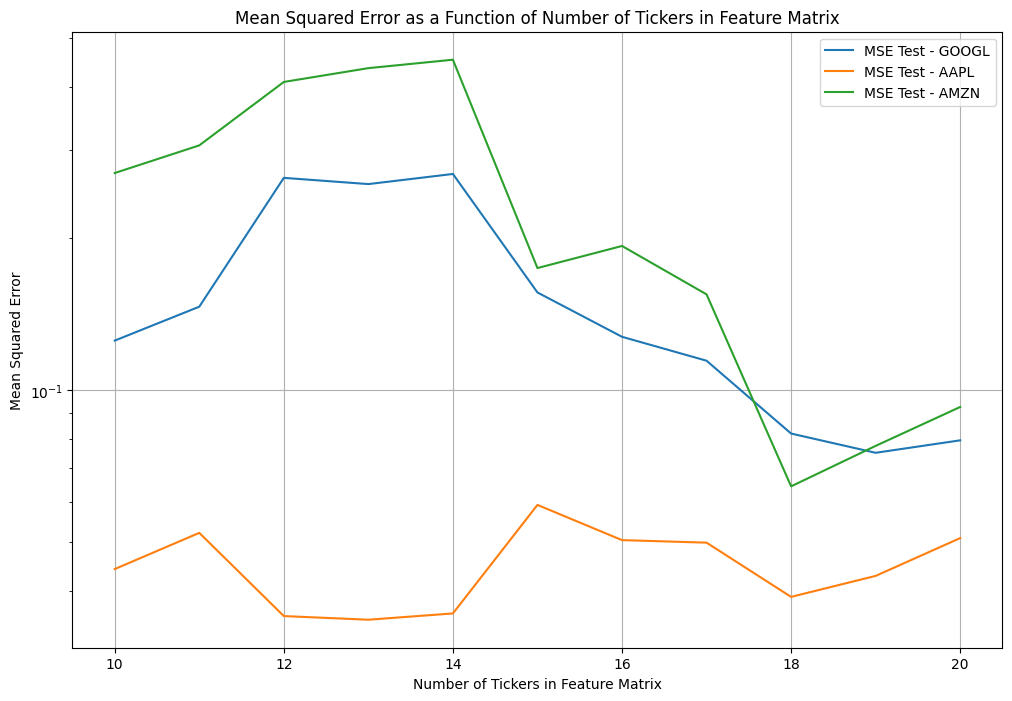

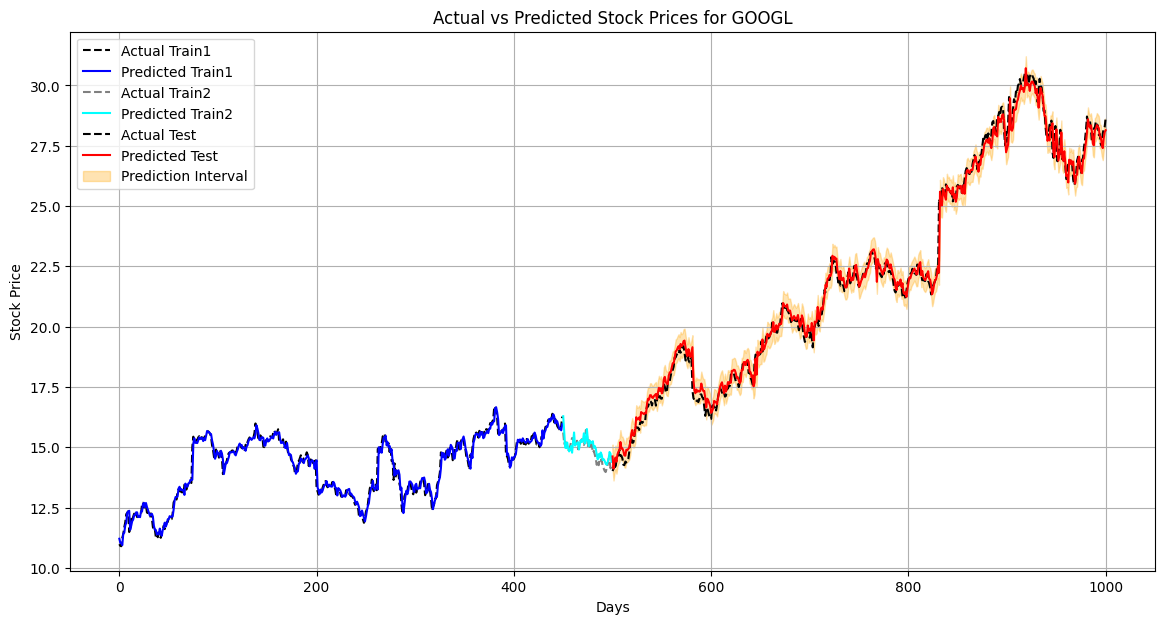

Coverage for the entire test period: 86.83%
Coverage for the first 10% of the test period: 88.00%


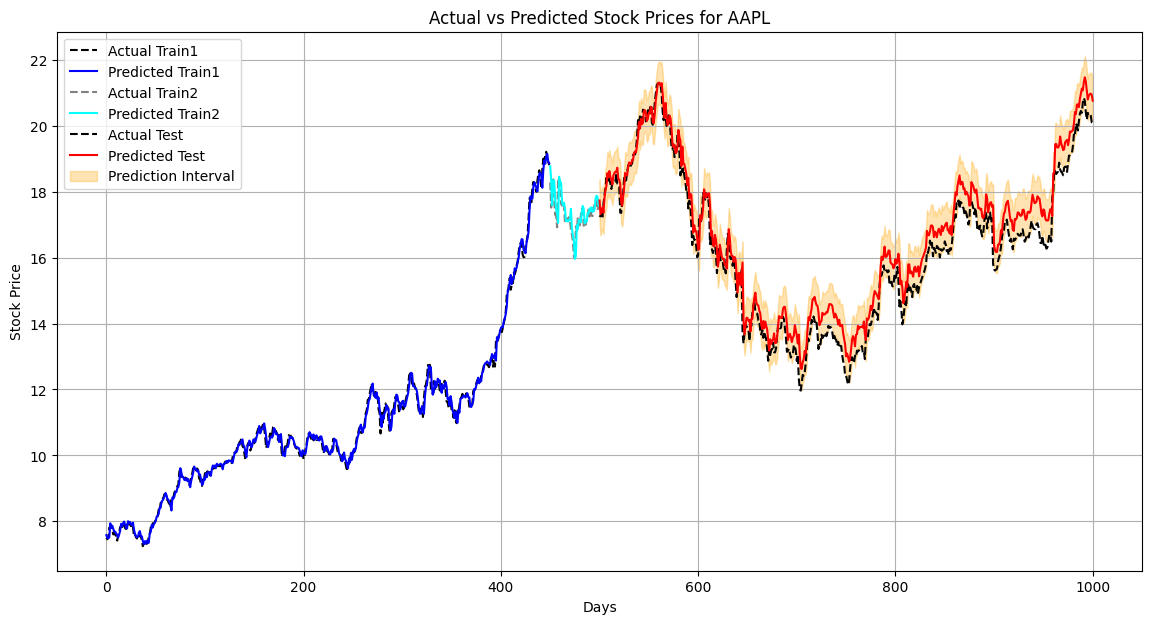

Coverage for the entire test period: 71.46%
Coverage for the first 10% of the test period: 98.00%


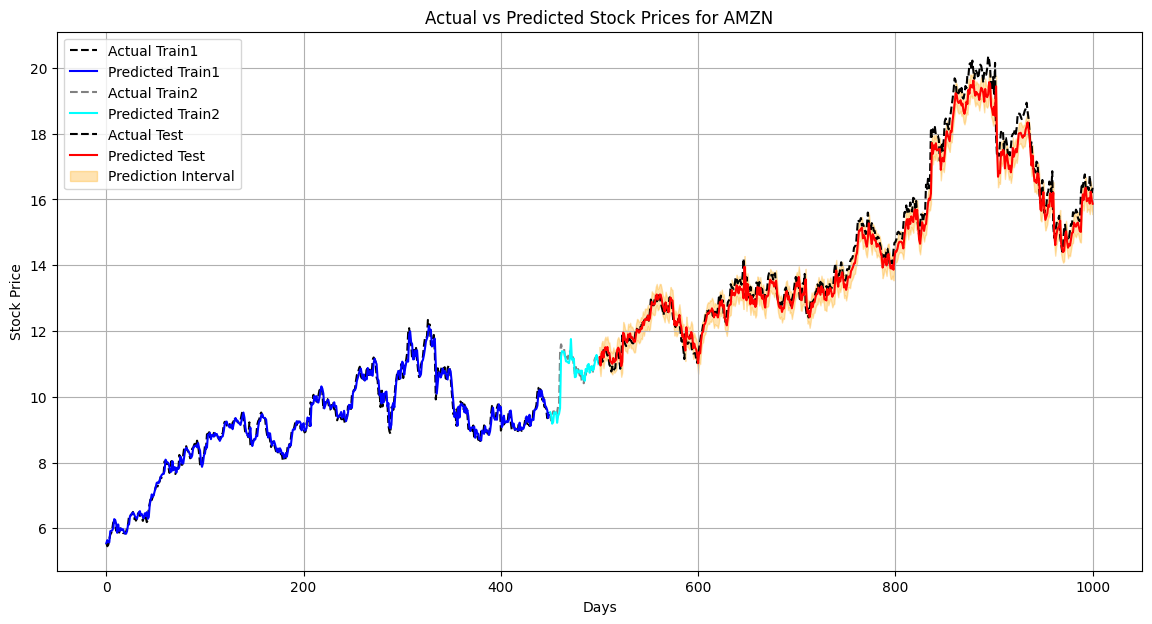

Coverage for the entire test period: 60.88%
Coverage for the first 10% of the test period: 90.00%


In [38]:
# Convert results to DataFrame
if results:
    results_df = pd.DataFrame(results)
    print("Results DataFrame Head:", results_df.head())

    # Save final results
    results_df.to_csv('final_results.csv', index=False)

    # Display the DataFrame in a Jupyter notebook environment
    display(results_df)

    # Plot Mean Squared Errors (MSE) for Google, Apple, and Amazon
    plt.figure(figsize=(12, 8))
    for target in target_tickers:
        plt.plot(results_df[results_df['Target_Ticker'] == target]['Num_Tickers'], results_df[results_df['Target_Ticker'] == target]['MSE_Test'], label=f'MSE Test - {target}', linestyle='solid')

    plt.xlabel('Number of Tickers in Feature Matrix')
    plt.ylabel('Mean Squared Error')
    plt.title('Mean Squared Error as a Function of Number of Tickers in Feature Matrix')
    plt.legend()
    plt.grid(True)
    plt.yscale('log')
    plt.show()

    # Plot the actual vs predicted stock prices for Google, Apple, and Amazon using the last evaluated model
    for target in target_tickers:
        plot_actual_vs_predicted(results_df[results_df['Target_Ticker'] == target]['Predictions'].iloc[-1], target)
else:
    print("No results to display.")
